In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import warnings 
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
h1n1 = pd.read_csv('../data/h1n1.csv', encoding='unicode_escape')

In [3]:
h1n1.head(15)

,Country,Cases,Deaths,Time
0,Algeria,5,0.0,7/6/09 09:00
1,Antigua and Barbuda,2,0.0,7/6/09 09:00
2,Argentina,2485,60.0,7/6/09 09:00
3,Australia,5298,10.0,7/6/09 09:00
4,Austria,19,0.0,7/6/09 09:00
5,Bahamas,7,0.0,7/6/09 09:00
6,Bahrain,15,0.0,7/6/09 09:00
7,Bangladesh,18,0.0,7/6/09 09:00
8,Barbados,12,0.0,7/6/09 09:00
9,Belgium,54,0.0,7/6/09 09:00


In [4]:
countries = list(h1n1['Country'].unique())
countries

['Algeria',
 'Antigua and Barbuda',
 'Argentina',
 'Australia',
 'Austria',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belgium',
 'Bermuda, UKOT',
 'Bolivia',
 'Bosnia and Hezegovina',
 'Brazil',
 'British Virgin Islands, UKOT',
 'Brunei Darussalam',
 'Bulgaria',
 'Cambodia',
 'Canada',
 'Cap Verde',
 'Cayman Islands, UKOT',
 'Chile',
 'China',
 'Colombia',
 'Cook Island',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 '\xa0\xa0\xa0\xa0\xa0French Polynesia, FOC',
 '\xa0\xa0\xa0\xa0\xa0Guadaloupe, FOC',
 '\xa0\xa0\xa0\xa0\xa0Martinique, FOC',
 '\xa0\xa0\xa0\xa0\xa0New Caledonia, FOC',
 '\xa0\xa0\xa0\xa0\xa0Saint Martin, FOC',
 'Germany',
 'Greece',
 'Guatemala\xa0',
 'Guyana',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran, Islamic Republic',
 'Iraq',
 'Ireland',
 'Israel',
 'I

Highest confirmed cases are belgium, germany and portugal. So let's look at those 

In [5]:
belgium= h1n1.loc[h1n1["Country"] == "Belgium"]
belgium = belgium.loc[belgium["Cases"] > 2]
belgium = belgium.reset_index(drop=True)


germany= h1n1.loc[h1n1["Country"] == "Germany"]
germany = germany.loc[germany["Cases"] > 2]
germany = germany.reset_index(drop=True)

portugal= h1n1.loc[h1n1["Country"] == "Portugal"]
portugal = portugal.loc[portugal["Cases"] > 2]
portugal = portugal.reset_index(drop=True)

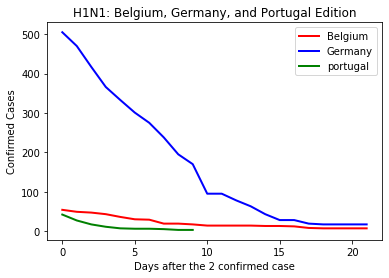

In [6]:
plt.plot(belgium.index, belgium['Cases'], 'r', linewidth = 2, label="Belgium")
plt.plot(germany.index, germany['Cases'],'b',linewidth = 2, label="Germany")
plt.plot(portugal.index, portugal['Cases'],'g',linewidth = 2, label="portugal")
plt.title("H1N1: Belgium, Germany, and Portugal Edition")
plt.xlabel("Days after the 2 confirmed case")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

In [7]:
#Order the dataframes by date

belgium[['Date', 'Time']] = belgium.Time.str.split(' ', expand=True)
belgium['Date'] = pd.to_datetime(belgium.Date)
belgium.sort_values(by='Date', ascending=True)
belgium = belgium.drop('Time', axis=1)
belgium = belgium.drop('Country', axis=1)
belgium = belgium.drop('Deaths', axis=1)
belgium = belgium.set_index("Date")

germany[['Date', 'Time']] = germany.Time.str.split(' ', expand=True)
germany['Date'] = pd.to_datetime(germany.Date)
germany.sort_values(by='Date', ascending=True)
germany = germany.drop('Time', axis=1)
germany = germany.drop('Country', axis=1)
germany = germany.drop('Deaths', axis=1)
germany = germany.set_index("Date")

portugal[['Date', 'Time']] = portugal.Time.str.split(' ', expand=True)
portugal['Date'] = pd.to_datetime(portugal.Date)
portugal.sort_values(by='Date', ascending=True)
portugal = portugal.drop('Time', axis=1)
portugal = portugal.drop('Country', axis=1)
portugal = portugal.drop('Deaths', axis=1)
portugal = portugal.set_index("Date")

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [9]:
def train_Country(country_data, n_input, n_features ):
    train_data, test_data = train_test_split(country_data, test_size=0.2, shuffle=False)
    
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    scaled_train_data = scaler.transform(train_data)
    scaled_test_data = scaler.transform(test_data)
    
    generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')

    model_summary = lstm_model.summary()
    
    print('Model summary: ', model_summary)
    
    lstm_model.fit_generator(generator,epochs=20)
    
    losses_lstm = lstm_model.history.history['loss']
    plt.figure(figsize=(12,4))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(0,21,1))
    plt.plot(range(len(losses_lstm)),losses_lstm);
    
    lstm_predictions_scaled = list()

    batch = scaled_train_data[-n_input:]
    current_batch = batch.reshape((1, n_input, n_features))

    for i in range(len(test_data)):   
        lstm_pred = lstm_model.predict(current_batch)[0]
        lstm_predictions_scaled.append(lstm_pred) 
        current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)
        
    print('LSTM Predictions Scaled: ', lstm_predictions_scaled)
    
    lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
    print('LSTM Predictions: ', lstm_predictions)
    
    return [lstm_predictions, test_data]

In [10]:
def plot_predictions_vs_real(predictions, test_data):
    test_data['LSTM_Predictions'] = predictions
    test_data['Cases'].plot(figsize = (16,5), legend=True)
    test_data['LSTM_Predictions'].plot(legend = True);
    
    return test_data

In [11]:
n_input = 7
n_features = 1

# Belgium #

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Model summary:  None
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
10/10 [==============================] - 0s 32ms/step - loss: 0.0021
Epoch 2/20
10/10 [==============================] - 0s 5ms/step - loss: 9.4391e-04
Epoch 3/20
10/10 [==============================] - 0s 15ms/step - loss: 6.3787e-04
Epoch 4/20
10/10 [==============================] - 0s 5ms/step - loss: 5.2646e-04
Epoch 5/20
10/10 [=====================

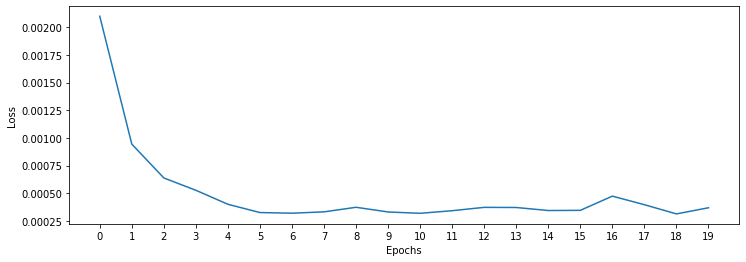

In [12]:
belgium_lstm = train_Country(belgium, n_input, n_features)

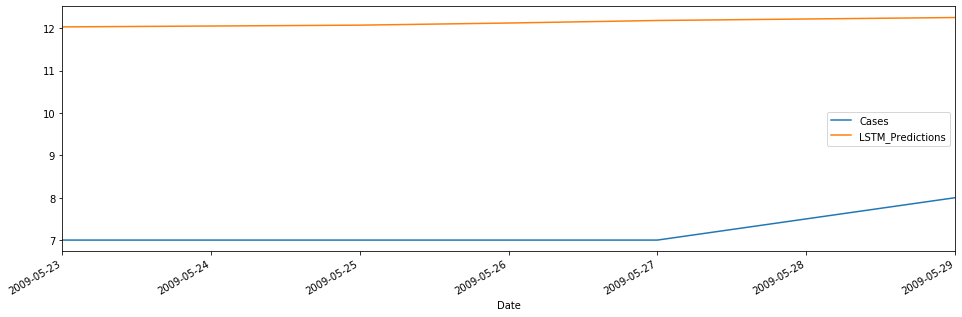

In [13]:
final_test_data = plot_predictions_vs_real(belgium_lstm[0], belgium_lstm[1])

In [14]:
from statsmodels.tools.eval_measures import rmse

rmse_belgium = rmse(final_test_data['Cases'], final_test_data['LSTM_Predictions'])
mse_belgium = rmse_belgium**2
mean_value = belgium['Cases'].mean()

print(f'MSE Error: {mse_belgium}\nRMSE Error: {rmse_belgium}\nMean: {mean_value}')

MSE Error: 24.462629486235056
RMSE Error: 4.945971035725448
Mean: 21.5


# Germany #

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Model summary:  None
Epoch 1/20
10/10 [==============================] - 0s 34ms/step - loss: 0.0251
Epoch 2/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 3/20
10/10 [==============================] - 0s 17ms/step - loss: 0.0067
Epoch 4/20
10/10 [==============================] - 0s 16ms/step - loss: 0.0051
Epoch 5/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 6/20
10/10 [==============================] - 0s 16ms/step - loss: 0.0027
Epoch 7/20


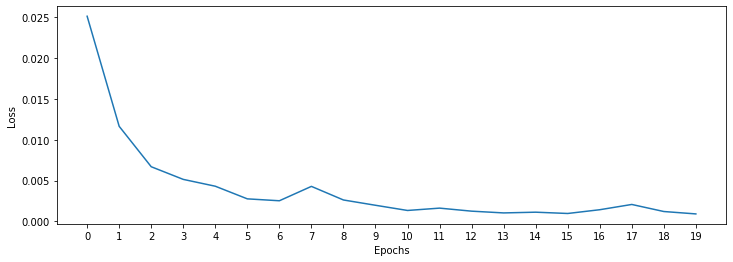

In [15]:
germany_lstm = train_Country(germany, n_input, n_features)

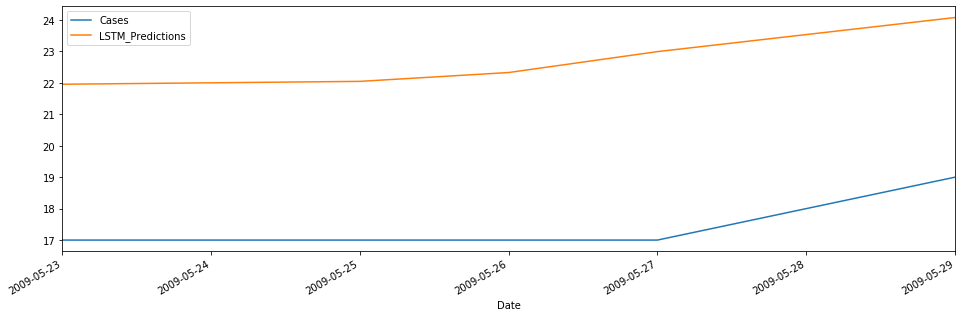

In [16]:
final_test_data = plot_predictions_vs_real(germany_lstm[0], germany_lstm[1])

In [17]:
rmse_germany = rmse(final_test_data['Cases'], final_test_data['LSTM_Predictions'])
mse_germany = rmse_germany**2
mean_value = germany['Cases'].mean()

print(f'MSE Error: {mse_germany}\nRMSE Error: {rmse_germany}\nMean: {mean_value}')

MSE Error: 28.011525747141185
RMSE Error: 5.292591590812688
Mean: 172.13636363636363


# Portugal #

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Model summary:  None
Epoch 1/20
1/1 [==============================] - 0s 330ms/step - loss: 8.7166e-05
Epoch 2/20
1/1 [==============================] - 0s 5ms/step - loss: 6.2819e-05
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 5.9523e-05
Epoch 4/20
1/1 [==============================] - 0s 104ms/step - loss: 4.9189e-06
Epoch 5/20
1/1 [==============================] - 0s 10ms/step - loss: 9.3225e-06
Epoch 6/20
1/1 [==============================] - 0s 108ms/step - loss: 3.2068e

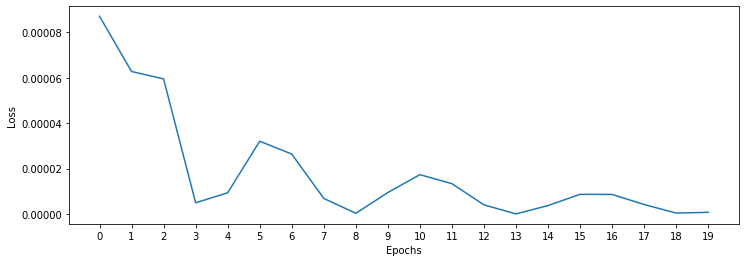

In [18]:
portugal_lstm = train_Country(portugal, n_input, n_features)

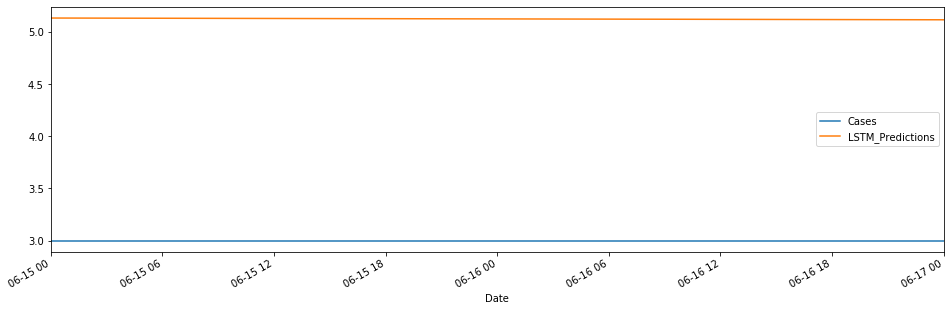

In [19]:
final_test_data = plot_predictions_vs_real(portugal_lstm[0], portugal_lstm[1])

In [20]:
rmse_portugal = rmse(final_test_data['Cases'], final_test_data['LSTM_Predictions'])
mse_portugal = rmse_portugal**2
mean_value = portugal['Cases'].mean()

print(f'MSE Error: {mse_portugal}\nRMSE Error: {rmse_portugal}\nMean: {mean_value}')

MSE Error: 4.525644581437083
RMSE Error: 2.127356242249305
Mean: 12.7


# Comparison #

In [21]:
from tabulate import tabulate

print(tabulate([
    ['Belgium LSTM Errors', mse_belgium, rmse_belgium], 
    ['Germany LSTM Errors', mse_germany, rmse_germany],
    ['Portugal LSTM Errors', mse_portugal, rmse_portugal]], 
    
    headers=['Model', 'MSE', "RMSE", "Mean"]))


Model                      MSE     RMSE
--------------------  --------  -------
Belgium LSTM Errors   24.4626   4.94597
Germany LSTM Errors   28.0115   5.29259
Portugal LSTM Errors   4.52564  2.12736
